In [284]:
# modules: --------------------------------------------------------------------
import numpy as np
import pandas as pd
from timeit import Timer
from os.path import exists
from collections import defaultdict
from IPython.core.display import display, HTML
import statistics
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pyro
# import tensorflow.compat.v2 as tf
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow
from tensorflow import float32
import torch
import copy
from tqdm import tqdm
from warnings import warn
from samplers import LangevinDynamics #notice in samplers, learning rate means step size
from samplers import MetropolisAdjustedLangevin
from precondSGLD import pSGLD
#import pyro
#from pyro.infer import MCMC, UncalibratedLangevin

# ULA and MALA

## Guassian Model

In [ ]:
np.random.seed(19)
torch.manual_seed(19)

if not torch.cuda.is_available():
    device = torch.device('cpu')
    torch.set_default_tensor_type('torch.FloatTensor')
else:
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

class GaussianDistribution(object):
    def __init__(self, mu, cov, device='cuda'):
        super(GaussianDistribution, self).__init__()

        self.mu = mu
        self.cov = cov
        self.precision = torch.inverse(cov)

        self.R = torch.linalg.cholesky(self.cov)
        self.normal = torch.distributions.normal.Normal(torch.zeros_like(mu),
            torch.ones_like(mu))

    def nl_pdf(self, x):
        return 0.5*(
            ((x - self.mu).T).matmul(self.precision)).matmul(x - self.mu)

    def sample(self):
        return self.R.matmul(self.normal.sample()) + self.mu


dim = 2

mu = torch.Tensor([1.2, .6], device=device)
cov = (
    0.9*(torch.ones([2, 2], device=device) -
         torch.eye(2, device=device)).T +
    torch.eye(2, device=device)*1.3
)
gaussian_dist = GaussianDistribution(mu, cov, device=device)

In [288]:
m = mu.numpy()
sigma = cov.numpy()
gaussian = tfd.MultivariateNormalFullCovariance(
           loc=m,
           covariance_matrix=sigma)

In [265]:
# np.random.seed(19)
# torch.manual_seed(19)

# if not torch.cuda.is_available():
#     device = torch.device('cpu')
#     torch.set_default_tensor_type('torch.FloatTensor')
# else:
#     device = torch.device('cuda')
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')

# class GaussianDistribution(object):
#     def __init__(self, mu, cov, device='cuda'):
#         super(GaussianDistribution, self).__init__()

#         self.mu = mu
#         self.cov = cov
#         self.precision = np.linalg.inv(cov)

#         self.R = np.linalg.cholesky(self.cov)
#         self.normal = torch.distributions.normal.Normal(torch.zeros_like(mu),
#             torch.ones_like(mu))

#     def nl_pdf(self, x):
#         return 0.5*(
#             ((x - self.mu).T).matmul(self.precision)).matmul(x - self.mu)

#     def sample(self):
#         return self.R.matmul(self.normal.sample()) + self.mu


# dim = 2

# mu = torch.Tensor([1.2, .6], device=device)
# cov = (
#     0.9*(torch.ones([2, 2], device=device) -
#          torch.eye(2, device=device)).T +
#     torch.eye(2, device=device)*1.3
# )
# gaussian_dist = GaussianDistribution(mu, cov, device=device)

In [292]:
# tfd = tfp.distributions
# dtype = np.float32

# # Target distribution is Standard Univariate Normal
# target = tfd.Normal(loc=dtype(0), scale=dtype(1))

# def target_log_prob(x):
#     return target.log_prob(x)

# tfp.mcmc.UncalibratedLangevin(
#         target_log_prob_fn=target_log_prob,
#         step_size=0.75)
# def target_log_prob(x):
#     return tf.constant(np.log(gaussian_dist.nl_pdf(x)).numpy())
# def target_log_prob(x):
#     return np.log(0.5*(
#             np.matmul(
#                 np.matmul((x - m).T,np.linalg.inv(sigma))
#                 ,x - m)))
# samples = tfp.mcmc.sample_chain(
#     num_results=10,
#     current_state=tf.zeros(2),
#     kernel=tfp.mcmc.UncalibratedLangevin(
#         target_log_prob_fn=gaussian.log_prob,
#         step_size=0.75)
#     ,num_burnin_steps=500
#     ,trace_fn=None
# )
# samples = MCMC(
#     kernel=tfp.mcmc.UncalibratedLangevin(
#         target_log_prob_fn=target_log_prob,
#         step_size=0.75),
#     num_samples=max_itr
#     #current_state=tf.constant([2.0, 1.0]),
#     #num_burnin_steps=500,
#     #trace_fn=None
# )

/Users/shushuz/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:310: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn("supplied `TransitionKernel` is not calibrated. Markov "


## ULA

/Users/shushuz/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:310: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn("supplied `TransitionKernel` is not calibrated. Markov "


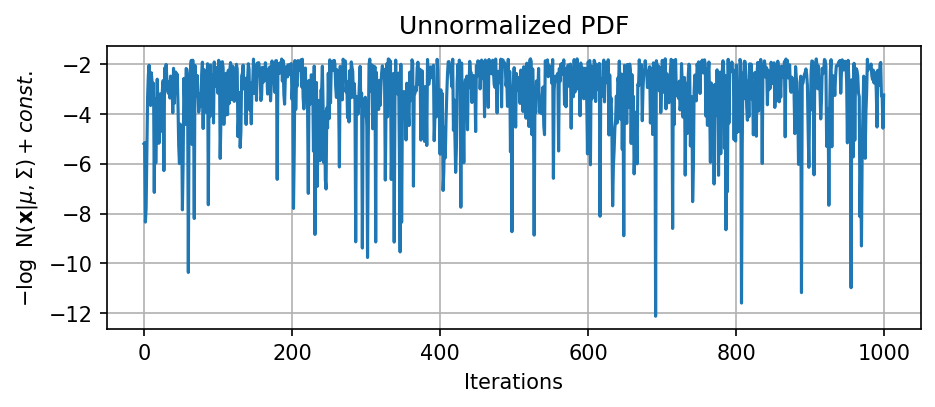

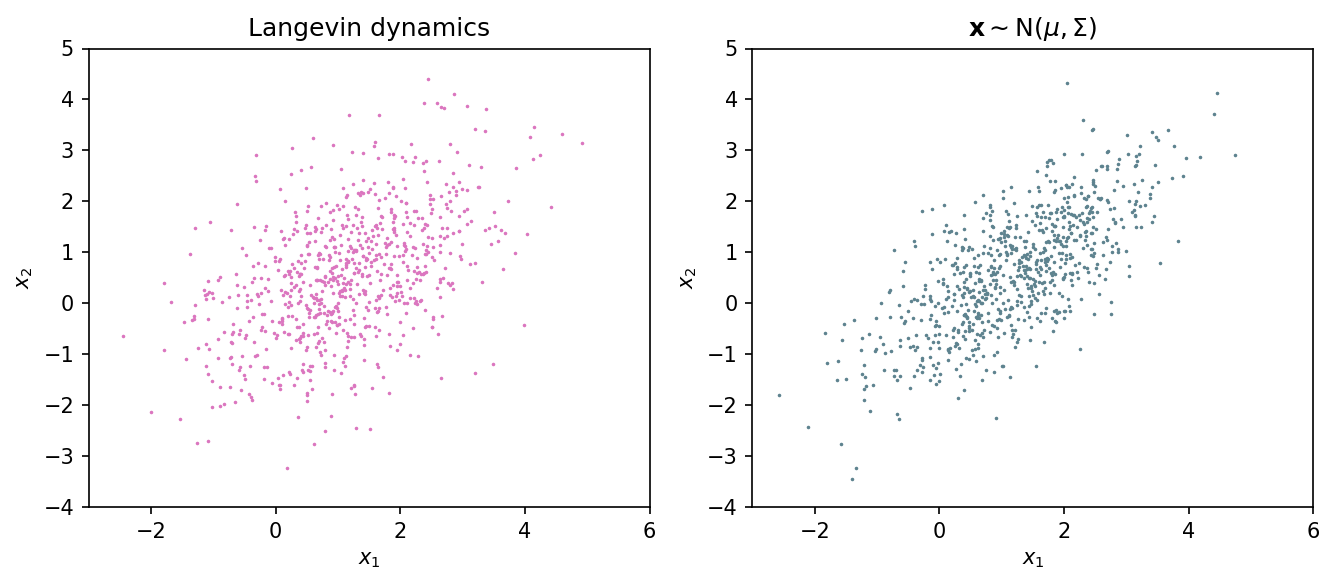

In [301]:
# ULA
## Define ULA sampler with `step_size` equal to 0.75
max_itr = 1000
samples = tfp.mcmc.sample_chain(
    num_results=max_itr,
    current_state=tf.zeros(2),
    kernel=tfp.mcmc.UncalibratedLangevin(
        target_log_prob_fn=gaussian.log_prob,
        step_size=0.75)
    ,num_burnin_steps=500
    ,trace_fn=None
)

est_samples = np.array(samples)[200:]
loss_log = np.apply_along_axis(gaussian.log_prob, 1, samples.numpy())

num_samples = est_samples.shape[0]
true_samples = np.zeros([num_samples, 2])
for j in range(num_samples):
    true_samples[j, :] = gaussian_dist.sample().cpu().numpy()

fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(loss_log)
plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

fig = plt.figure(dpi=150, figsize=(9, 4))
plt.subplot(121)
plt.scatter(est_samples[:, 0], est_samples[:, 1], s=.5,
            color="#db76bf")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title("Langevin dynamics")
plt.subplot(122)
p2 = plt.scatter(true_samples[:, 0], true_samples[:, 1], s=.5,
                 color="#5e838f")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title(r"$\mathbf{x} \sim \mathrm{N}(\mu, \Sigma)$")
plt.tight_layout()
plt.show()

## MALA

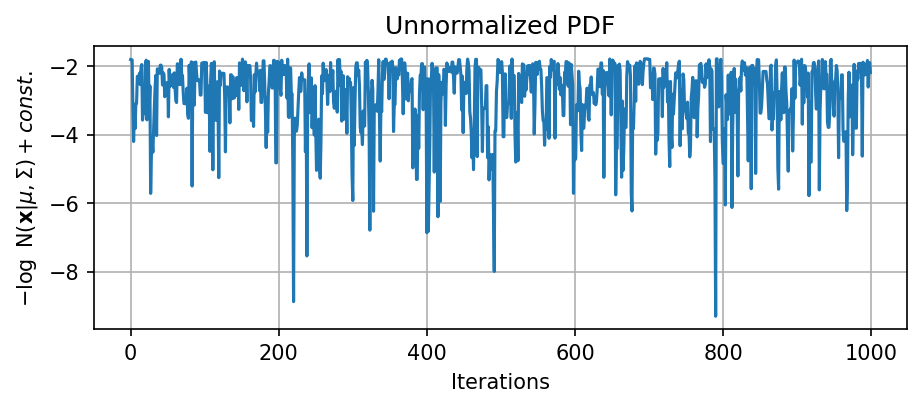

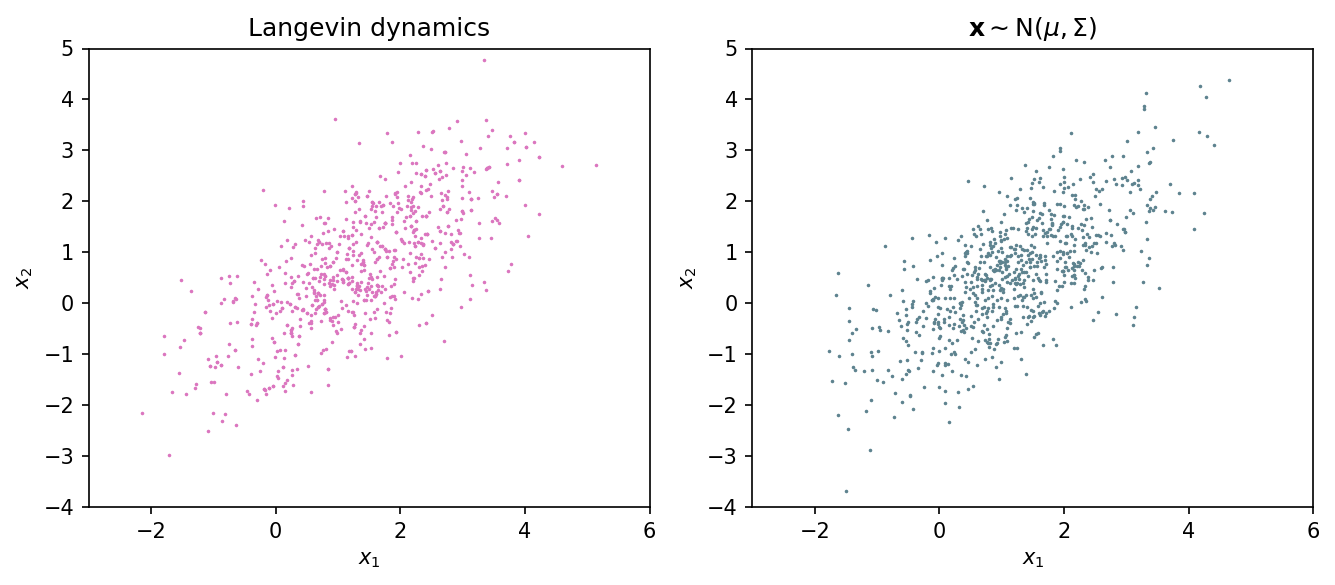

In [302]:
# MALA
## Define MALA sampler with `step_size` equal to 0.75
samples = tfp.mcmc.sample_chain(
    num_results=max_itr,
    current_state=tf.zeros(2),
    kernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
        target_log_prob_fn=gaussian.log_prob,
        step_size=0.75)
    ,num_burnin_steps=500
    ,trace_fn=None
)

est_samples = np.array(samples)[200:]
loss_log = np.apply_along_axis(gaussian.log_prob, 1, samples.numpy())

num_samples = est_samples.shape[0]
true_samples = np.zeros([num_samples, 2])
for j in range(num_samples):
    true_samples[j, :] = gaussian_dist.sample().cpu().numpy()

fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(loss_log)
plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

fig = plt.figure(dpi=150, figsize=(9, 4))
plt.subplot(121)
plt.scatter(est_samples[:, 0], est_samples[:, 1], s=.5,
            color="#db76bf")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title("Langevin dynamics")
plt.subplot(122)
p2 = plt.scatter(true_samples[:, 0], true_samples[:, 1], s=.5,
                 color="#5e838f")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title(r"$\mathbf{x} \sim \mathrm{N}(\mu, \Sigma)$")
plt.tight_layout()
plt.show()

# Stochastic Gradient Version of ULA and MALA

## SG-ULA

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 6025.54it/s]


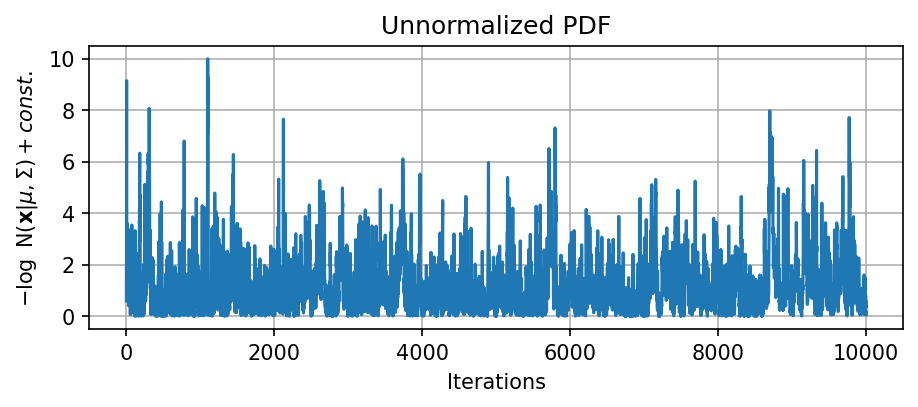

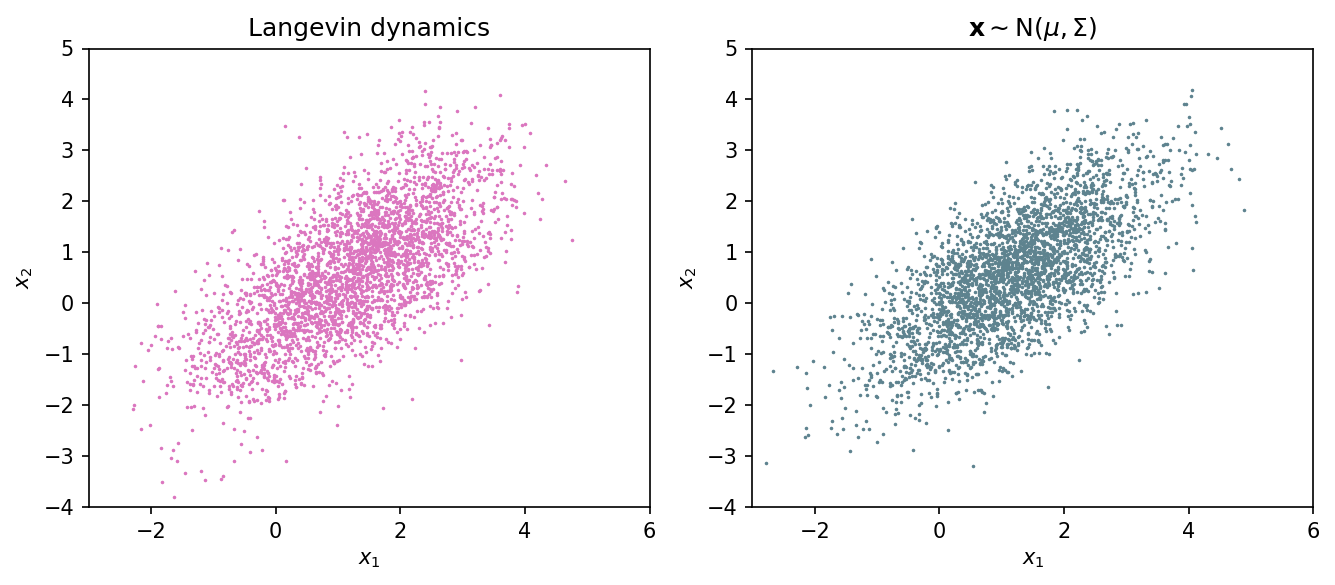

In [31]:
x = torch.zeros([2], requires_grad=True, device=device)
langevin_dynamics = LangevinDynamics(
    x,
    gaussian_dist.nl_pdf,
    lr=1e-1,
    lr_final=4e-2,
    max_itr=max_itr,
    device=device
)

hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = langevin_dynamics.sample()
    loss_log.append(loss)
    if j%3 == 0:
        hist_samples.append(est.cpu().numpy())
est_samples = np.array(hist_samples)[200:]

num_samples = est_samples.shape[0]
true_samples = np.zeros([num_samples, 2])
for j in range(num_samples):
    true_samples[j, :] = gaussian_dist.sample().cpu().numpy()

fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(loss_log)
plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

fig = plt.figure(dpi=150, figsize=(9, 4))
plt.subplot(121)
plt.scatter(est_samples[:, 0], est_samples[:, 1], s=.5,
            color="#db76bf")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title("Langevin dynamics")
plt.subplot(122)
p2 = plt.scatter(true_samples[:, 0], true_samples[:, 1], s=.5,
                 color="#5e838f")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title(r"$\mathbf{x} \sim \mathrm{N}(\mu, \Sigma)$")
plt.tight_layout()
plt.show()

In [40]:
langevin_dynamics.sample()

(tensor([1.2606, 0.1926]), 0.2265414595603943)

## SG-MALA

100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 3006.22it/s]


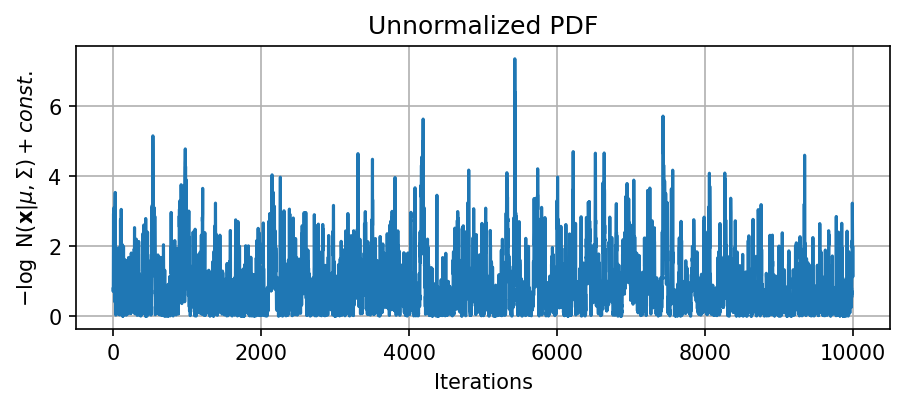

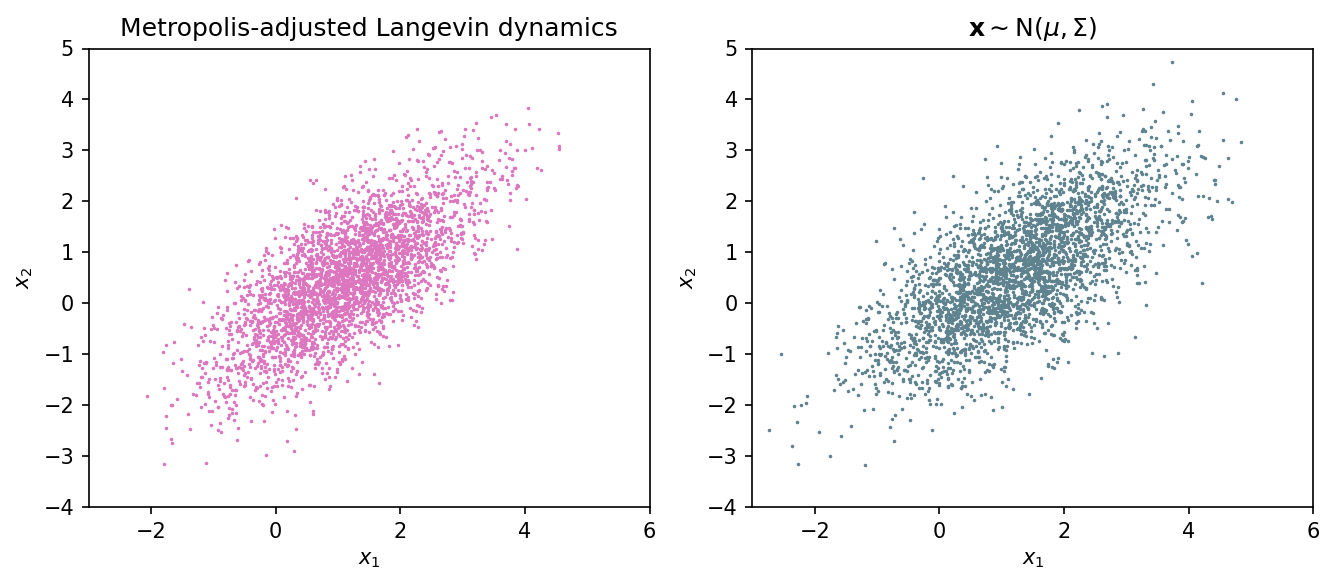

In [35]:
x = torch.zeros([2], requires_grad=True, device=device)
max_itr = int(1e4)
mala = MetropolisAdjustedLangevin(
    x,
    gaussian_dist.nl_pdf,
    lr=1e-1,
    lr_final=4e-2,
    max_itr=max_itr,
    device=device
)

hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = mala.sample()
    loss_log.append(loss)
    if j%3 == 0:
        hist_samples.append(est.cpu().numpy())
est_samples = np.array(hist_samples)[200:]

num_samples = est_samples.shape[0]
true_samples = np.zeros([num_samples, 2])
for j in range(num_samples):
    true_samples[j, :] = gaussian_dist.sample().cpu().numpy()

fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(loss_log)
plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

fig = plt.figure(dpi=150, figsize=(9, 4))
plt.subplot(121)
plt.scatter(est_samples[:, 0], est_samples[:, 1], s=.5,
            color="#db76bf")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title("Metropolis-adjusted Langevin dynamics")
plt.subplot(122)
p2 = plt.scatter(true_samples[:, 0], true_samples[:, 1], s=.5,
                 color="#5e838f")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-3, 6])
plt.ylim([-4, 5])
plt.title(r"$\mathbf{x} \sim \mathrm{N}(\mu, \Sigma)$")
plt.tight_layout()
plt.show()